# Cueva & Wei reproduction

In this notebook we will try to reproduce the results of Cueva and Wei's 2018 paper "Emergence of grid-like representations by training recurrent neural networks to perform spatial localization" [arXiv:1803.07770](https://arxiv.org/abs/1803.07770). The paper will be cited along this notebook to guide the code, since this is a reconstruction.

This will be done with a continuous-time RNN as described in the paper.

This effort comprises the initial steps of a theoretical neuroscience project involving neural behaviour regarding spatial localization.

For questions or suggestions please contact kkohn@itba.edu.ar

## Packages

We use numpy and the CTRNN package https://github.com/madvn/CTRNN 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from CTRNN import CTRNN   #Continuous time Recurrent Neural Network package (pip install CTRNN)

### Model Description
Our network model consists of a set of recurrently connected units (N = 100). The dynamics of
each unit in the network $u_i(t)$ is governed by the standard continuous-time RNN equation:

 $$ τ\frac{dx_i(t)}{dt} = −x_i(t) + \sum_{j=1}^N W^{rec}_{ij} u_j(t)
 + \sum_{k=1}^N W^{in}_{ik} I_k(t) + b_i + ξ_i(t) \tag{1}$$ for i = 1, . . . , N. 

The activity of each unit, $u_i(t)$, is related to the activation of that unit, $x_i(t)$,
through a nonlinearity which in this study we take to be $u_i(t) = tanh(x_i(t))$. Each unit receives
input from other units through the recurrent weight matrix $W^{rec}$ and also receives external input,
$I(t)$, that enters the network through the weight matrix $W^{in}$. Each unit has two sources of bias,
$b_i$ which is learned and $ξ_i(t)$ which represents noise intrinsic to the network and is taken to be
Gaussian with zero mean and constant variance. The network was simulated using the Euler method
for T = 500 timesteps of duration Δt = τ /10.

$$ y_i(t+Δt)=y_i(t)+Δt \frac{dy_i}{dt} $$

To perform a 2D navigation task with the RNN, we linearly combine the firing rates of units in
the network to estimate the current location of the animal. The responses of the two linear readout
neurons, $y_1(t)$ and $y_2(t)$, are given by the following equation:
$$y_j (t) = \sum^N_{i=1} W_{ji}^{out} u_i(t) \tag{2}$$

In [2]:
# parameters
N = 100 # no. of units
T = 500 # no. of Euler timesteps
step_size = T/10 # Euler timestep size

#network set up
network = CTRNN(size=N, step_size=step_size)

print(network.biases)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


### Input to the network
The network inputs and outputs were inspired by simple spatial navigation tasks in 2D open environments. The task resembles dead-reckoning (sometimes referred to as path integration), which is
ethologically relevant for many animal species (Darwin, 1873; Mittelstaedt & Mittelstaedt, 1980;
Etienne & Jeffery, 2004; McNaughton et al., 2006). To be more specific, the inputs to the network
were the animal’s speed and direction at each time step. Experimentally, it has been shown that the
velocity signals exist in EC (Sargolini et al., 2006; Kropff et al., 2015; Hinman et al., 2016), and
there is also evidence that such signals are necessary for grid formation (Winter et al., 2015a;b).

Throughout the paper, we adopt the common assumption that the head direction of the animal coincides
with the actual moving direction. The outputs were the x- and y-coordinates of the integrated
position. The direction of the animal is modeled by modified Brownian motion to increase the
probability of straight-runs, in order to be consistent with the typical rodent’s behavior in an open
environment. The usage of such simple movement statistics has the advantage of having full control
of the simulated trajectories. However, for future work it would be very interesting to test the model
using different animals’ real movement trajectories to see how the results might change.

Special care is taken when the animal is close to the boundary. The boundary of the environment
will affect the statistics of the movement, as the animal cannot cross the boundary. This fact was
reflected in the model by re-sampling the angular input variable until the input angle did not lead
the animal outside the boundary. In the simulations shown below, the animal always starts from the
center of the arena, but we verified that the results are insensitive to the starting locations.

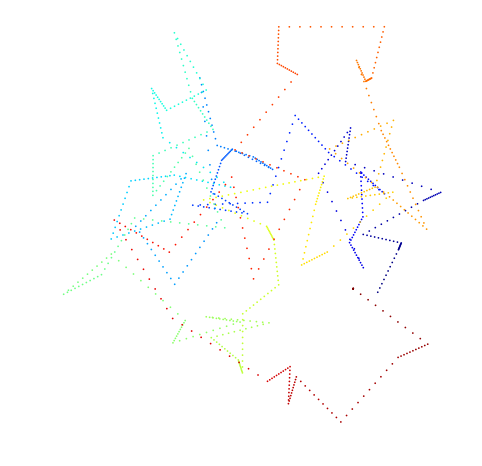

In [9]:
# 2D Brownian motion simulation

x = np.cumsum(np.random.randn(N))  # cummulative sum of N random gaussian jumps 
y = np.cumsum(np.random.randn(N))

# Display path, color gradient indicates time progression
k = 10
x2 = np.interp(np.arange(N * k), np.arange(N) * k, x)
y2 = np.interp(np.arange(N * k), np.arange(N) * k, y)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(x2, y2, c=range(N * k), linewidths=0,
           marker='o', s=3, cmap=plt.cm.jet,)
ax.axis('equal')
ax.set_axis_off()

# Calculate velocities and directions for each timestep

# Velocities: (x2 - x1)/timestep
xaux = np.concatenate([np.array([0]), x[0:-1]]) # [0 x{0} ... x{N-1}]
yaux = np.concatenate([np.array([0]), y[0:-1]])
vx = (x - xaux)/step_size 
vy = (y - yaux)/step_size 
vx[0] = 0   #set initial velocities to 0
vy[0] = 0

# Directions: tan θ = (y2 − y1)/(x2 − x1)
dirs = np.arctan((x - xaux)/(y - yaux))
dirs[0] = 0

#print('x=',x)
#print('xaux=',xaux)

#print('y=',y)
#print('yaux=',yaux)

#print('vx=',vx)
#print('vy=',vy)

#print('dirs=', dirs)

### Training
We optimized the network parameters $W_{rec}, W_{in}, b$ and $Wout$ to minimize the squared error in equation (3) between target x- and y-coordinates from a two dimensional navigation task (performed in rectangular, hexagonal, and triangular arenas) and the network outputs generated according to equation (2).

$$ E = \frac{1}{MT N_{out}}\sum^{M,T,N_{out}}_{m,t,j=1}
(y_j (t, m) − y^{target}_j(t, m))^2\tag{3}$$

Parameters were updated with the *Hessian-free algorithm* (Martens & Sutskever, 2011) using minibatches of size M = 500 trials. In addition to minimizing the error function in equation (3) we regularized the input and output weights according to equation (4) and the squared firing rates of the units (referred to as metabolic cost) according to equation (5). In sum, the training aims to minimize a loss function, that consists of the error of the animal, the metabolic cost, and a penalty for large network parameters.

$$R_{L2} = \frac{1}{NN_{in}}\sum^{N,N_{in}}_{i,j=1}
(W^{in}_{ij})^2 +\frac{1}{NN_{out}}\sum^{N,N_{out}}_{i,j=1}
(W^{out}_{ij})^2 \tag{4}$$

$$R_{FR} = \frac{1}{NTM}\sum^{N,T,M}_{i,t,m=1}
u_i(t, m)^2 \tag{5}$$

### Network simulation

In [ ]:
# simulate network
outputs = []
for _ in range(int(T/step_size)):
    network.euler_step([0]*N) # zero external_inputs
    outputs.append([network.outputs[i] for i in range(N)])
outputs = np.asarray(outputs)